In [1]:
import generator

import numpy as np

import matplotlib.pyplot as plt

from skopt.plots import plot_gaussian_process
from skopt import Optimizer

In [2]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [3]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [4]:
import pandas as pd

ids = [211, 321, -211, -321]

refs = {}

for id in ids:
    
    refs[id] = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [5]:
inst = {
    'Print:quiet': 'on',

    'Beams:frameType': '2',

    'Beams:idA': '2212',
    'Beams:idB': '2212',

    'Beams:eA': '158',
    'Beams:eB': '0',

    'SoftQCD:all': 'on',

    'Tune:pp': '1',

    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on',

    'MultipartonInteractions:ecmRef': '1800',
    }

In [6]:
optim_param = 'MultipartonInteractions:ecmRef'

In [7]:
def objective(x, n_events, refs, agregate=None):

    new_val = x[0]

    inst[optim_param] = f'{new_val}'

    data, sigma = generator.generate(n_events, inst, bins)
    res =  generator.get_score(data, sigma, n_events, bins, refs, agregate)

    return res

In [10]:
def plot_optimizer(res, n_iter, max_iters=5):
    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 1)
    # Plot GP(x) + contours
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=True,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
    # Plot EI(x)
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=True,
                               show_observations=False,
                               show_mu=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])

In [27]:
n_initial_points = 20

opt_gp = Optimizer([(1., 7000.)],
                   base_estimator="GP",
                   n_initial_points=n_initial_points,
                   acq_optimizer="sampling", acq_func='EI',
                   random_state=42, n_jobs=-1)

Iteration number 1


100%|██████████| 1000000/1000000 [02:04<00:00, 8006.93it/s]


Iteration number 11


100%|██████████| 1000000/1000000 [02:13<00:00, 7517.74it/s]


Iteration number 21


100%|██████████| 1000000/1000000 [02:09<00:00, 7709.14it/s]


Iteration number 31


100%|██████████| 1000000/1000000 [02:10<00:00, 7683.89it/s]


Iteration number 41


100%|██████████| 1000000/1000000 [02:14<00:00, 7456.78it/s]


Iteration number 51


100%|██████████| 1000000/1000000 [02:09<00:00, 7745.45it/s]


Iteration number 61


100%|██████████| 1000000/1000000 [02:11<00:00, 7621.46it/s]


Iteration number 71


100%|██████████| 1000000/1000000 [02:11<00:00, 7597.18it/s]


Iteration number 81


100%|██████████| 1000000/1000000 [02:12<00:00, 7560.47it/s]


Iteration number 91


100%|██████████| 1000000/1000000 [02:11<00:00, 7590.70it/s]


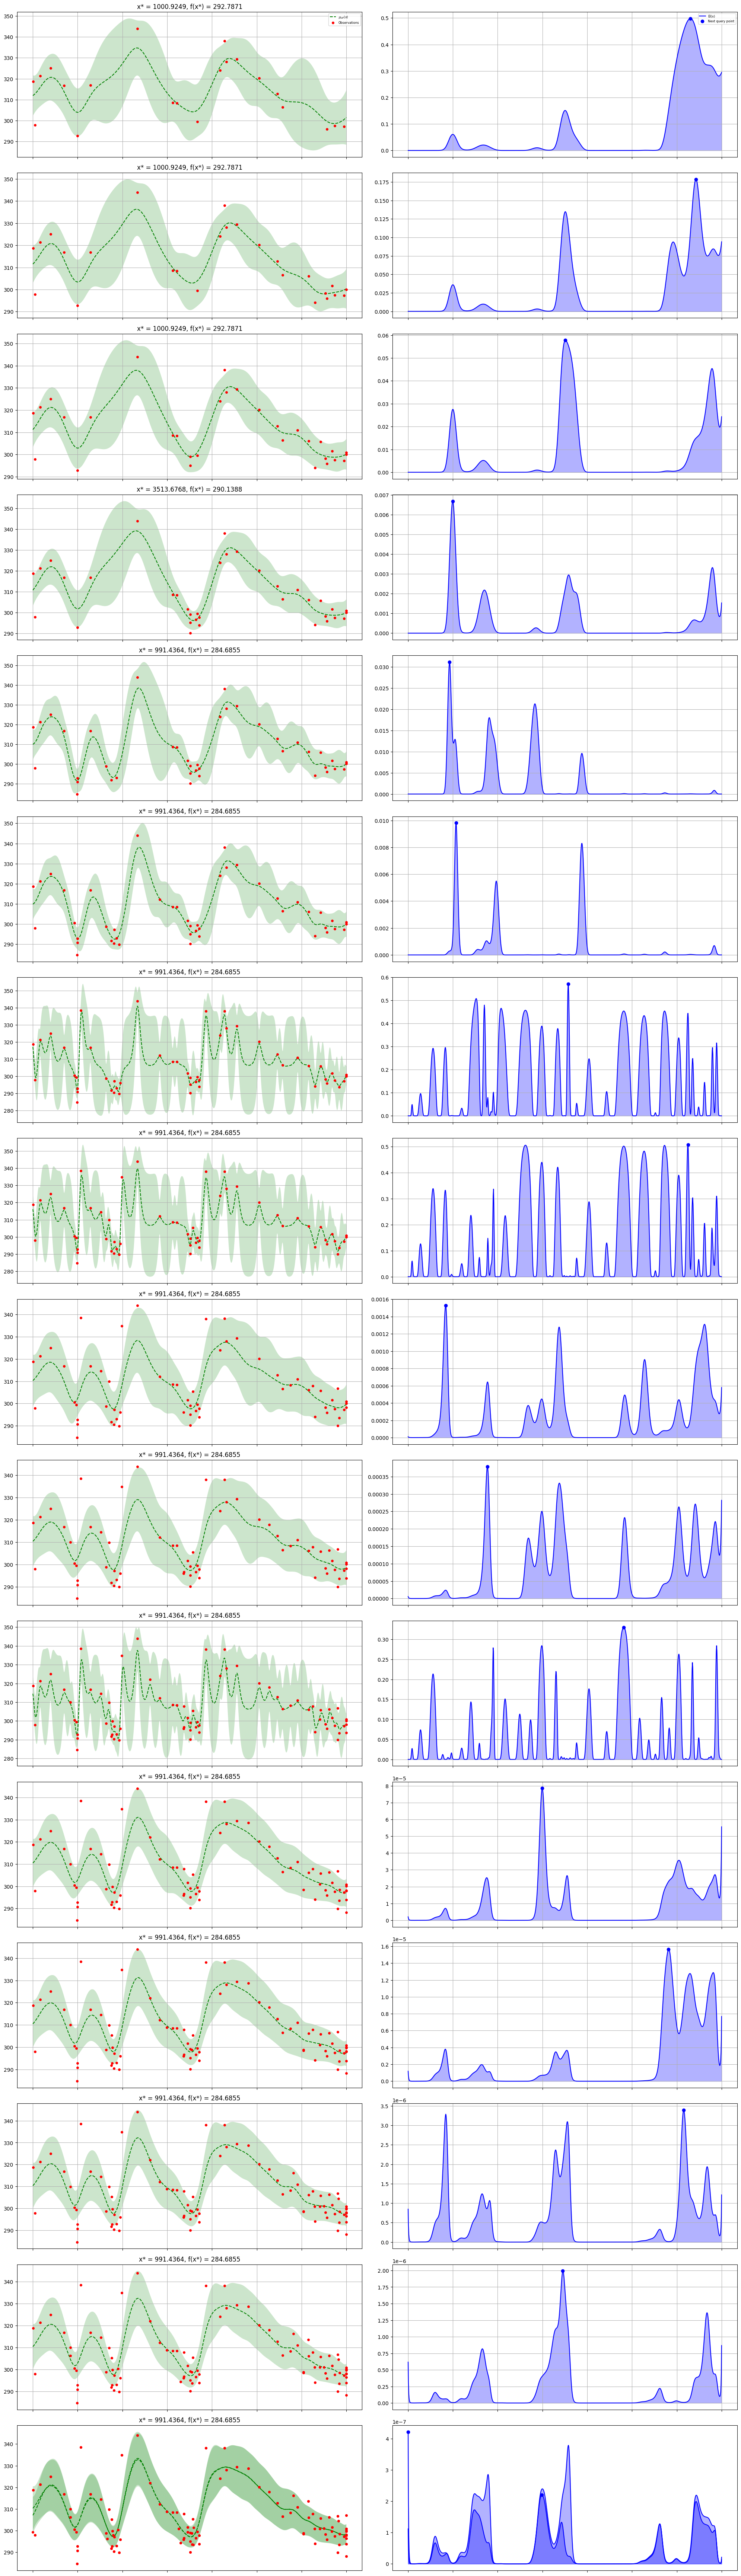

In [28]:
n_events = int(1e6)

fig = plt.figure(figsize=(20, 80))

itrs = 100

for i in range(itrs):

    if i % 10 == 0:
        print(f'Iteration number {i + 1}')
    
    next_x = opt_gp.ask()
    f_val = objective(next_x, n_events, refs, np.sum)
    res = opt_gp.tell(next_x, f_val)
    
    if (i >= n_initial_points) * (((i - n_initial_points) % 5 == 0) + (i == (itrs - 1))):
    
        plot_optimizer(res, n_iter=(i - n_initial_points) // 5,
                       max_iters=(itrs - n_initial_points) // 5 + 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

> ## Error evaluation

In [23]:
stat = 20
ns = [5, 6, 7]

res_pi = {}
res_k = {}

In [24]:
for n in ns:

    res_pi[n] = []
    res_k[n] = []

    print(f'Evuluate statistics for 10^{n} events:')
    
    for _ in range(stat):

        pi, k = objective([5576.0], int(10 ** n), {211: refs[211], 321: refs[321]})

        res_pi[n].append(pi)
        res_k[n].append(k)

    print('\n')

Evuluate statistics for 10^5 events:


NameError: name 'objective' is not defined

In [17]:
print('pi-mesons')

for n in ns:

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_pi[n]):.5}\n\
        STD: {np.std(res_pi[n]):.5}\n')

pi-mesons
For 10^5 events
        Mean value: 137.57
        STD: 13.975

For 10^6 events
        Mean value: 118.49
        STD: 1.8588

For 10^7 events
        Mean value: 114.66
        STD: 0.55429



In [33]:
print('K-mesons')

for n in ns:

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_k[n]):.5}\n\
        STD: {np.std(res_k[n]):.5}\n')

K-mesons
For 10^5 events
        Mean value: 70.243
        STD: 13.146

For 10^6 events
        Mean value: 46.04
        STD: 2.9377

For 10^7 events
        Mean value: 43.63
        STD: 0.70773



> ## Bins distribution test

In [74]:
def f(y_hat, y, y_hat_err, y_err):

    return (y_hat - y) / (y_hat_err ** 2 + y_err ** 2) ** 0.5

In [75]:
n_events = int(1e5)

In [76]:
per_bin_reses = []
mask = 1

for i in range(100):

    data, sigma = generator.generate(n_events, inst, bins)
    xsect, err = generator.xsect_calc(data, sigma, n_events, bins)
    res = generator.calc_metric(f, xsect, err, refs[211], bins, 211)
    
    per_bin_reses.append(res)

    mask = mask * (np.where(np.isnan(res), False, True))

100%|██████████| 100000/100000 [00:13<00:00, 7513.42it/s]


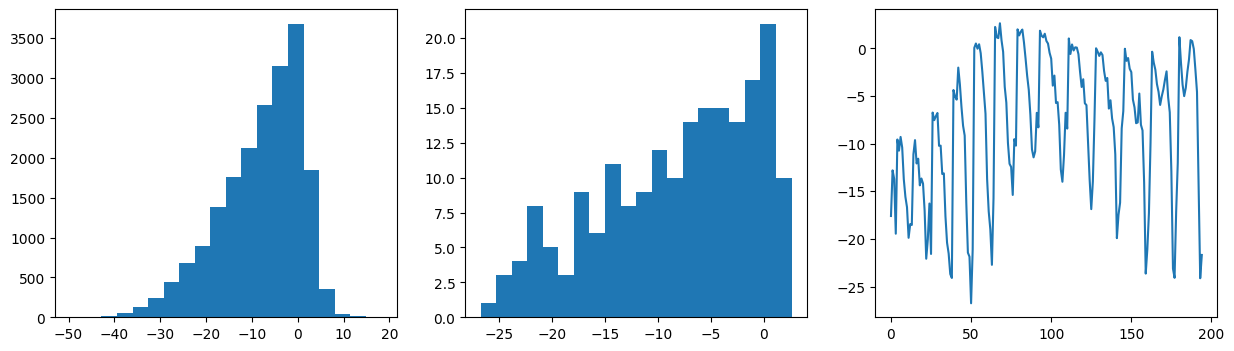

In [78]:
plt.figure(figsize=(15, 4))

per_bin_clean = np.array(per_bin_reses)[:, np.bool8(mask)]
plt.subplot(1, 3, 1)
plt.hist(np.concatenate(per_bin_clean), bins=20)

per_bin_avg = per_bin_clean.mean(axis=0)
plt.subplot(1, 3, 2)
plt.hist(per_bin_avg, bins=20)

plt.subplot(1, 3, 3)
plt.plot(per_bin_avg);

In [79]:
n_events = int(1e6)

In [80]:
per_bin_reses = []
mask = 1

for i in range(100):

    data, sigma = generator.generate(n_events, inst, bins)
    xsect, err = generator.xsect_calc(data, sigma, n_events, bins)
    res = generator.calc_metric(f, xsect, err, refs[211], bins, 211)
    
    per_bin_reses.append(res)

    mask = mask * (np.where(np.isnan(res), False, True))

100%|██████████| 1000000/1000000 [02:12<00:00, 7533.56it/s]


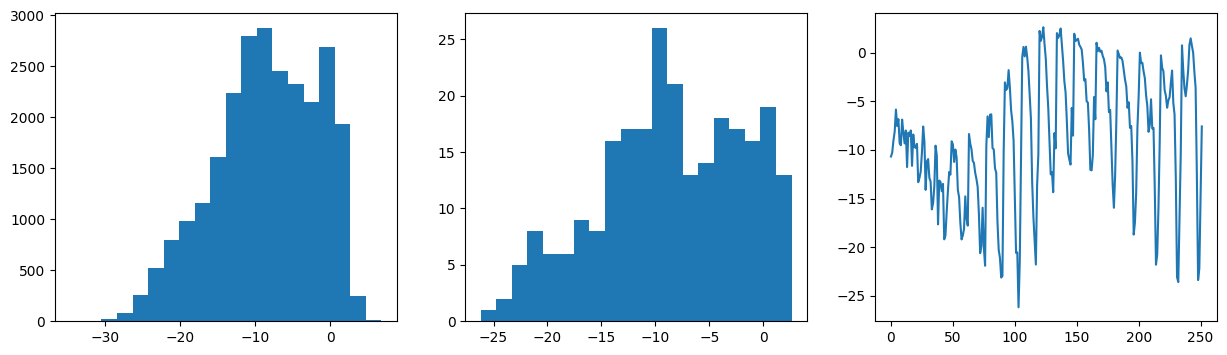

In [81]:
plt.figure(figsize=(15, 4))

per_bin_clean = np.array(per_bin_reses)[:, np.bool8(mask)]
plt.subplot(1, 3, 1)
plt.hist(np.concatenate(per_bin_clean), bins=20)

per_bin_avg = per_bin_clean.mean(axis=0)
plt.subplot(1, 3, 2)
plt.hist(per_bin_avg, bins=20)

plt.subplot(1, 3, 3)
plt.plot(per_bin_avg);

In [57]:
n_events = int(1e7)

In [58]:
per_bin_reses = []
mask = 1

for i in range(100):

    data, sigma = generator.generate(n_events, inst, bins)
    xsect, err = generator.xsect_calc(data, sigma, n_events, bins)
    res = generator.calc_metric(f, xsect, err, refs[211], bins, 211)
    
    per_bin_reses.append(res)

    mask = mask * (np.where(np.isnan(res), False, True))

100%|██████████| 10000000/10000000 [23:04<00:00, 7224.79it/s]


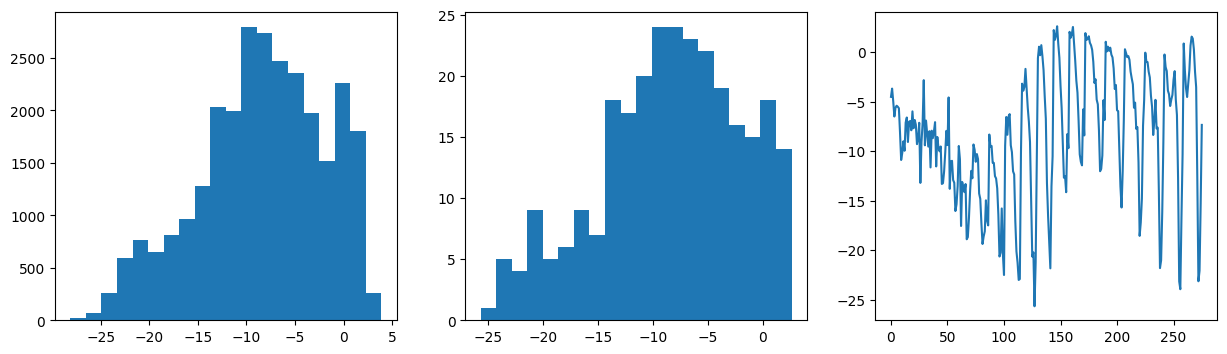

In [73]:
plt.figure(figsize=(15, 4))

per_bin_clean = np.array(per_bin_reses)[:, np.bool8(mask)]
plt.subplot(1, 3, 1)
plt.hist(np.concatenate(per_bin_clean), bins=20)

per_bin_avg = per_bin_clean.mean(axis=0)
plt.subplot(1, 3, 2)
plt.hist(per_bin_avg, bins=20)

plt.subplot(1, 3, 3)
plt.plot(per_bin_avg);